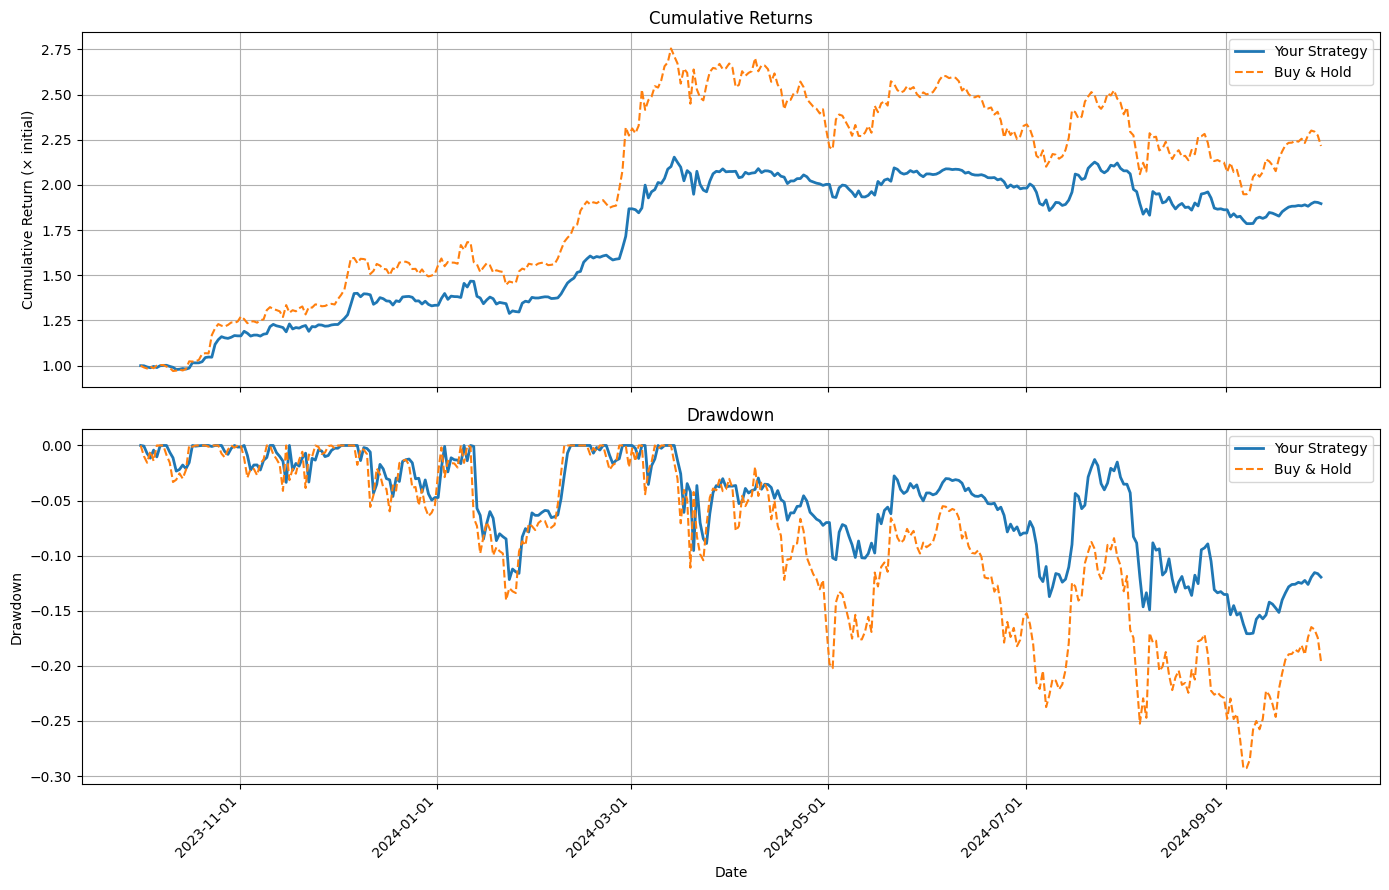

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) CSV 불러오기 + datetime 파싱
strategy_df = pd.read_csv('/home/tako/Documents/yonghan/Macro-Micro-Trader/data/results/total/trade/btc_total.csv')
strategy_df['datetime'] = pd.to_datetime(strategy_df['datetime'])
strategy_df.set_index('datetime', inplace=True)

price_df = pd.read_csv('/home/tako/Documents/yonghan/Macro-Micro-Trader/data/btc_day1.csv')
price_df['datetime'] = pd.to_datetime(price_df['datetime'])
price_df.set_index('datetime', inplace=True)

# 2) 전략 기간(start~end)에 맞춰 Buy&Hold 자르고, 전략의 인덱스로 재색인(ffill)
start, end = strategy_df.index.min(), strategy_df.index.max()
price_slice   = price_df.loc[start:end]
price_aligned = price_slice.reindex(strategy_df.index, method='ffill')

# 3) 누적수익률과 드로우다운 계산
# 3-A) 전략 (return이 % 단위라고 가정)
strategy_df['cum_return']  = 1 + strategy_df['return'] / 100
strategy_df['running_max'] = strategy_df['cum_return'].cummax()
strategy_df['drawdown']    = strategy_df['cum_return'] / strategy_df['running_max'] - 1

# 3-B) Buy&Hold
price_aligned['daily_ret']    = price_aligned['close'].pct_change().fillna(0)
price_aligned['cum_return']   = (1 + price_aligned['daily_ret']).cumprod()
price_aligned['running_max']  = price_aligned['cum_return'].cummax()
price_aligned['drawdown']     = price_aligned['cum_return'] / price_aligned['running_max'] - 1

# 4) 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(14,  9), sharex=True)

# (A) 누적수익률
axes[0].plot(strategy_df.index,   strategy_df['cum_return'],
             label='Your Strategy', linewidth=2)
axes[0].plot(price_aligned.index, price_aligned['cum_return'],
             label='Buy & Hold',   linestyle='--')
axes[0].set_title('Cumulative Returns')
axes[0].set_ylabel('Cumulative Return (× initial)')
axes[0].legend(loc='best')
axes[0].grid(True)

# (B) 드로우다운
axes[1].plot(strategy_df.index,   strategy_df['drawdown'],
             label='Your Strategy', linewidth=2)
axes[1].plot(price_aligned.index, price_aligned['drawdown'],
             label='Buy & Hold',   linestyle='--')
axes[1].set_title('Drawdown')
axes[1].set_ylabel('Drawdown')
axes[1].set_xlabel('Date')
axes[1].legend(loc='best')
axes[1].grid(True)

# 5) x축을 실제 날짜로 포맷하고, y축은 플레인 숫자로
for ax in axes:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()


  Period  Return (%)  Max Drawdown (%)  Sharpe Ratio
0   Bull  175.768832        -14.039390       3.68407
1   Bear  -14.885485        -27.875339      -0.41685


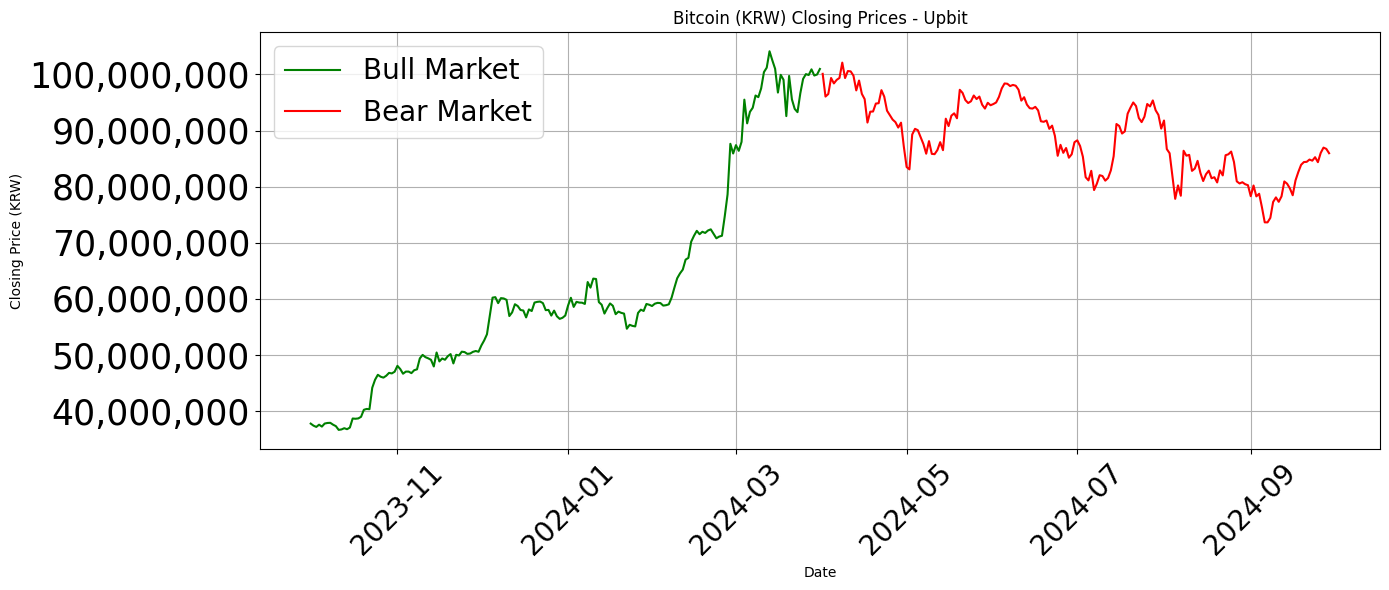

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter
import numpy as np

# 업비트 비트코인 일별 데이터 가져오기 함수 (시가·종가 포함)
def get_upbit_btc_daily(from_date, to_date):
    url = "https://api.upbit.com/v1/candles/days"
    market = "KRW-BTC"
    count = 200

    all_data = []
    to_dt = datetime.strptime(to_date, "%Y-%m-%d")
    
    while True:
        params = {
            "market": market,
            "count": count,
            "to": to_dt.strftime("%Y-%m-%dT%H:%M:%S") + "Z"
        }
        resp = requests.get(url, params=params)
        data = resp.json()
        if not data:
            break
        all_data.extend(data)
        
        last_dt = datetime.strptime(data[-1]["candle_date_time_utc"], "%Y-%m-%dT%H:%M:%S")
        if last_dt.date() <= datetime.strptime(from_date, "%Y-%m-%d").date():
            break
        to_dt = last_dt

    df = pd.DataFrame(all_data)
    df["date"] = pd.to_datetime(df["candle_date_time_kst"]).dt.date
    df = df[["date", "opening_price", "trade_price"]].sort_values("date").reset_index(drop=True)
    df = df[df["date"] >= datetime.strptime(from_date, "%Y-%m-%d").date()]
    df.rename(columns={"trade_price": "close"}, inplace=True)
    return df

# --- 기간 정의
bull_start, bull_end = "2023-10-01", "2024-03-31"
bear_start, bear_end = "2024-04-01", "2024-09-30"

# 전체 데이터 가져오기 (bull 시작부터 bear 끝까지)
df = get_upbit_btc_daily(bull_start, bear_end)

# 시장 유형 분류
df["market_type"] = "neutral"
df.loc[(df["date"] >= datetime.strptime(bull_start, "%Y-%m-%d").date()) & 
       (df["date"] <= datetime.strptime(bull_end,   "%Y-%m-%d").date()), "market_type"] = "bull"
df.loc[(df["date"] >= datetime.strptime(bear_start, "%Y-%m-%d").date()) & 
       (df["date"] <= datetime.strptime(bear_end,   "%Y-%m-%d").date()), "market_type"] = "bear"

# 성과지표 계산 함수
def calculate_metrics(period_df):
    period_df = period_df.copy()
    period_df["daily_ret"] = period_df["close"].pct_change().fillna(0)
    period_df["equity"]    = (1 + period_df["daily_ret"]).cumprod()
    period_df["peak"]      = period_df["equity"].cummax()
    period_df["drawdown"]  = period_df["equity"] / period_df["peak"] - 1
    mdd    = period_df["drawdown"].min()
    mean_r = period_df["daily_ret"].mean()
    std_r  = period_df["daily_ret"].std(ddof=1)
    sharpe = (mean_r / std_r) * np.sqrt(252) if std_r != 0 else np.nan
    return mdd, sharpe

# 기간별 성과 계산
results = []
for name, (start, end) in [
    ("Bull", (bull_start, bull_end)),
    ("Bear", (bear_start, bear_end))
]:
    mask = (df["date"] >= datetime.strptime(start, "%Y-%m-%d").date()) & \
           (df["date"] <= datetime.strptime(end,   "%Y-%m-%d").date())
    period_df = df.loc[mask].reset_index(drop=True)

    buy_price  = period_df.loc[0, "opening_price"]
    sell_price = period_df.loc[period_df.index[-1], "close"]
    ret = (sell_price / buy_price - 1) * 100  # % 수익률

    mdd, sharpe = calculate_metrics(period_df)

    results.append({
        "Period":           name,
        "Return (%)":       ret,
        "Max Drawdown (%)": mdd * 100,
        "Sharpe Ratio":     sharpe
    })

# 결과 출력
result_df = pd.DataFrame(results)
print(result_df)

# 시각화
plt.figure(figsize=(14, 6))
for market in ["bull", "bear", "neutral"]:
    tmp = df[df["market_type"] == market]
    if tmp.empty: 
        continue
    if market == "bull":
        plt.plot(tmp["date"], tmp["close"], label="Bull Market",  color="green")
    elif market == "bear":
        plt.plot(tmp["date"], tmp["close"], label="Bear Market",  color="red")
    else:
        plt.plot(tmp["date"], tmp["close"], color="lightgray", alpha=0.5)

ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))  # 콤마 구분자
plt.title("Bitcoin (KRW) Closing Prices - Upbit")
plt.xlabel("Date")
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=25)
plt.ylabel("Closing Price (KRW)")
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()